<a href="https://colab.research.google.com/github/navrat/EVA_phase1_2022_23/blob/main/S8_Custom_Resnet/S8_CUSTOM_RESNET_CIFAR_GRADCAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Running a model from models.py
## Running a model on CIFAR10 dataset
## Leveraing GradCam to produce activation maps

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%autoreload 2
# Future print function
from __future__ import print_function

# Load modules/models from EVA course
!git clone https://github.com/navrat/EVA_phase1_2022_23 -q --quiet
!mv EVA_phase1_2022_23/S7_CIFAR_RESNET_GRADCAM/* .
print("Loaded EVA8 Modules and Models")

!rm -rf EVA_phase1_2022_23

# Installing latest Albumentation library
!pip install -U git+https://github.com/albu/albumentations -q --quiet

# For inline matplotlib plotting
%matplotlib inline

Loaded EVA8 Modules and Models
  Preparing metadata (setup.py) ... done


## Loading train and test datasets

In [3]:
from utils import *
from main import *

dataset = dataset_cifar10(batch_size=128)

CUDA availability ? True


In [4]:
# Train dataloader
trainloader = dataset.loader(train_flag=True)

# Test dataloader
testloader = dataset.loader(train_flag=False)

target_classes = dataset.classes

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./Data/cifar-10-python.tar.gz to ./Data
Files already downloaded and verified


In [5]:
dataset.data_summary_stats()

training data
Files already downloaded and verified
[0.49139968 0.48215841 0.44653091]
[0.24703223 0.24348513 0.26158784]
testing data
Files already downloaded and verified
[0.49421428 0.48513139 0.45040909]
[0.24665252 0.24289226 0.26159238]
total data
(60000, 32, 32, 3)
[0.49186878 0.48265391 0.44717728]
[0.24697121 0.24338894 0.26159259]


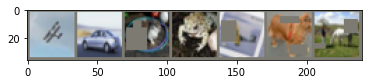

['plane', 'car', 'cat', 'frog', 'plane', 'dog', 'horse']


In [ ]:
# # sample training images
plot_sample_images(trainloader, target_classes, 7)

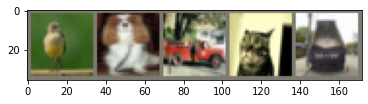

['bird', 'dog', 'truck', 'cat', 'truck']


In [ ]:
# sample testing images
plot_sample_images(testloader, target_classes, 5)

In [9]:
# Defining the model - RESTNET
from main import *
import torch

# Loading ResNet18 Model
net = nnet_model()

# Using cuda if available
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

# Sending network to device
net = net.to(device)

==> Building model..
cuda


In [10]:
!pip install torchsummary
from torchsummary import summary

# Model Summary
summary(net, input_size=(3, 32, 32))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
    

In [ ]:
# Load train and test model
# from main import *
# criterion, optimizer, scheduler, n_epochs = model_training_setup(net)
import torch.optim as optim
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)


In [ ]:
# Load train and test model
from main import execute_run
trainObj, testObj = execute_run(net, device, trainloader, testloader, EPOCHS=20, lr=0.01)
print('Finished Training')


Epoch: 0,Loss=1.28 Batch_id=390 Accuracy=44.72: 100%|██████████| 391/391 [00:41<00:00,  9.39it/s]


Test set: Average loss: 0.0094, Accuracy: 5719/10000 (57.19%)



Epoch: 1,Loss=0.89 Batch_id=390 Accuracy=59.17: 100%|██████████| 391/391 [00:39<00:00,  9.82it/s]


Test set: Average loss: 0.0079, Accuracy: 6629/10000 (66.29%)



Epoch: 2,Loss=0.85 Batch_id=390 Accuracy=66.13: 100%|██████████| 391/391 [00:39<00:00,  9.84it/s]


Test set: Average loss: 0.0063, Accuracy: 7187/10000 (71.87%)



Epoch: 3,Loss=0.83 Batch_id=390 Accuracy=70.17: 100%|██████████| 391/391 [00:41<00:00,  9.36it/s]


Test set: Average loss: 0.0067, Accuracy: 7224/10000 (72.24%)



Epoch: 4,Loss=0.81 Batch_id=390 Accuracy=73.13: 100%|██████████| 391/391 [00:39<00:00,  9.82it/s]


Test set: Average loss: 0.0047, Accuracy: 7929/10000 (79.29%)



Epoch: 5,Loss=0.81 Batch_id=390 Accuracy=75.37: 100%|██████████| 391/391 [00:40<00:00,  9.57it/s]


Test set: Average loss: 0.0049, Accuracy: 7890/10000 (78.90%)



Epoch: 6,Loss=0.49 Batch_id=390 Accuracy=80.73: 100%|██████████| 391/391 [00:39<00:00,  9.81it/s]


Test set: Average loss: 0.0034, Accuracy: 8564/10000 (85.64%)



Epoch: 7,Loss=0.57 Batch_id=390 Accuracy=82.23: 100%|██████████| 391/391 [00:39<00:00,  9.81it/s]


Test set: Average loss: 0.0033, Accuracy: 8571/10000 (85.71%)



Epoch: 8,Loss=0.50 Batch_id=390 Accuracy=83.11: 100%|██████████| 391/391 [00:40<00:00,  9.71it/s]


Test set: Average loss: 0.0032, Accuracy: 8621/10000 (86.21%)



Epoch: 9,Loss=0.35 Batch_id=390 Accuracy=83.33: 100%|██████████| 391/391 [00:40<00:00,  9.57it/s]


Test set: Average loss: 0.0032, Accuracy: 8617/10000 (86.17%)



Epoch: 10,Loss=0.37 Batch_id=390 Accuracy=83.74: 100%|██████████| 391/391 [00:39<00:00,  9.78it/s]


Test set: Average loss: 0.0031, Accuracy: 8657/10000 (86.57%)



Epoch: 11,Loss=0.64 Batch_id=390 Accuracy=84.00: 100%|██████████| 391/391 [00:40<00:00,  9.68it/s]


Test set: Average loss: 0.0031, Accuracy: 8654/10000 (86.54%)



Epoch: 12,Loss=0.43 Batch_id=390 Accuracy=84.51: 100%|██████████| 391/391 [00:39<00:00,  9.82it/s]


Test set: Average loss: 0.0030, Accuracy: 8675/10000 (86.75%)



Epoch: 13,Loss=0.42 Batch_id=390 Accuracy=85.02: 100%|██████████| 391/391 [00:39<00:00,  9.84it/s]


Test set: Average loss: 0.0030, Accuracy: 8691/10000 (86.91%)



Epoch: 14,Loss=0.43 Batch_id=390 Accuracy=85.12: 100%|██████████| 391/391 [00:40<00:00,  9.73it/s]


Test set: Average loss: 0.0030, Accuracy: 8702/10000 (87.02%)



Epoch: 15,Loss=0.39 Batch_id=390 Accuracy=85.12: 100%|██████████| 391/391 [00:41<00:00,  9.39it/s]


Test set: Average loss: 0.0030, Accuracy: 8683/10000 (86.83%)



Epoch: 16,Loss=0.44 Batch_id=390 Accuracy=84.98: 100%|██████████| 391/391 [00:41<00:00,  9.39it/s]


Test set: Average loss: 0.0030, Accuracy: 8693/10000 (86.93%)



Epoch: 17,Loss=0.38 Batch_id=390 Accuracy=85.20: 100%|██████████| 391/391 [00:41<00:00,  9.52it/s]


Test set: Average loss: 0.0029, Accuracy: 8699/10000 (86.99%)



Epoch: 18,Loss=0.52 Batch_id=390 Accuracy=85.16: 100%|██████████| 391/391 [00:42<00:00,  9.28it/s]


Test set: Average loss: 0.0029, Accuracy: 8712/10000 (87.12%)



Epoch: 19,Loss=0.38 Batch_id=390 Accuracy=85.22: 100%|██████████| 391/391 [00:39<00:00,  9.79it/s]


Test set: Average loss: 0.0030, Accuracy: 8705/10000 (87.05%)

Finished Training
Finished Training


In [6]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [ ]:
!ls /content/gdrive/MyDrive
model_save_name = 's7_resnet18_classifier.pt'
path = F"/content/gdrive/MyDrive/{model_save_name}" 
torch.save(net.state_dict(), path)

 1709451CONSOLIDATEDREPORT15062018.pdf
'2019_20_ITRV NAVEEN RATHANI.pdf'
'AI Boon or Bane - Conclusion .docx'
'boltt echo 1000 video.mp4'
'Colab Notebooks'
'Fireboltt - Order #12946 confirmation.pdf'
 Hampi
'IIMb PGPEM intro docs'
 IMG_20171227_164104155.jpg
 itr_ack_naveen_rathani_ay_2020_21.pdf
'KickDrum Quiz Jan2020.gslides'
'Naveen Rathani - Resume (1).pdf'
'Naveen Rathani Resume 2019.pdf'
'Naveen Rathani - Resume.pdf'
 Naveen_Rathani_Resume.pdf
 printable-rent-receipt.docx
 printable-rent-receipt.gdoc
 Print….pdf
'Product Image.jpg'
 Quizzes.gdoc
 s7_resnet18_classifier.pt
 sample_cell_phones_data.csv
 semi_sup_learning
'Shikharam documents association'
'Sobha Royal Pavillion Legal Docs'
'Sudhanshu class 08062021 NLP'
 Tableau
'TA_ WO (revised).docx'
 test_folder_delete
'Untitled document.gdoc'
'Untitled spreadsheet.gsheet'
'Vendor ITR Declaration Form- naveen rathani.docx'
'Web and social media analytics'


In [11]:
model_save_name = 's7_resnet18_classifier.pt'
path = F"/content/gdrive/MyDrive/{model_save_name}"
net.load_state_dict(torch.load(path))

<All keys matched successfully>

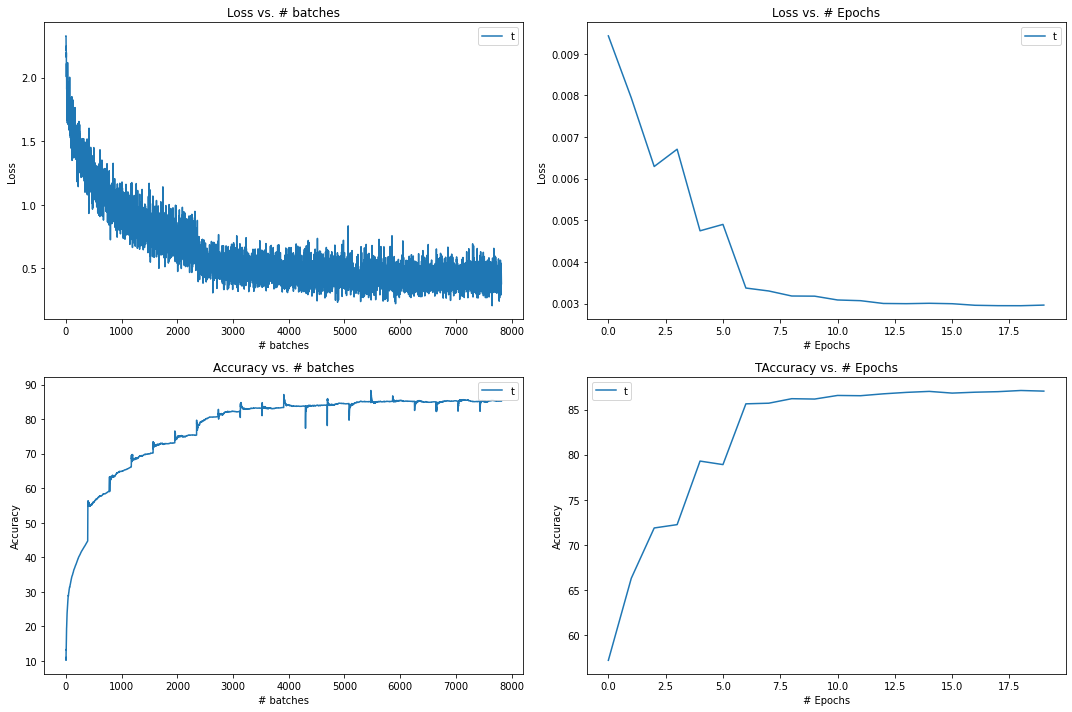

In [ ]:
from utils import plot_evolution_graph
plot_evolution_graph(trainObj, testObj)

In [ ]:
def calClassAccuracy(net, dataloader, classes, device):
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            images,labels = images.to(device),labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(4):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1


    for i in range(10):
        print('Accuracy of %5s : %2d %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))

In [ ]:
model_eval_f(net, device, testloader, target_classes)


Test set: Average loss: -8.9989, Accuracy: 8705/10000 (87.05%)


 class wise performance: 

  classes  accuracy
0   plane      81.6
1     car      93.4
2    bird      73.8
3     cat      86.5
4    deer      78.0
5     dog      90.6
6    frog      90.8
7   horse      89.7
8    ship      93.0
9   truck      93.1
              precision    recall  f1-score   support

        bird       0.84      0.82      0.83      1000
         car       0.94      0.93      0.94      1000
         cat       0.74      0.74      0.74      1000
        deer       0.85      0.86      0.86      1000
         dog       0.83      0.78      0.80      1000
        frog       0.91      0.91      0.91      1000
       horse       0.91      0.91      0.91      1000
       plane       0.87      0.90      0.88      1000
        ship       0.91      0.93      0.92      1000
       truck       0.90      0.93      0.92      1000

    accuracy                           0.87     10000
   macro avg       0.87      0.87    


 # of incorrect images predicted in test dataset of 10000: 1295


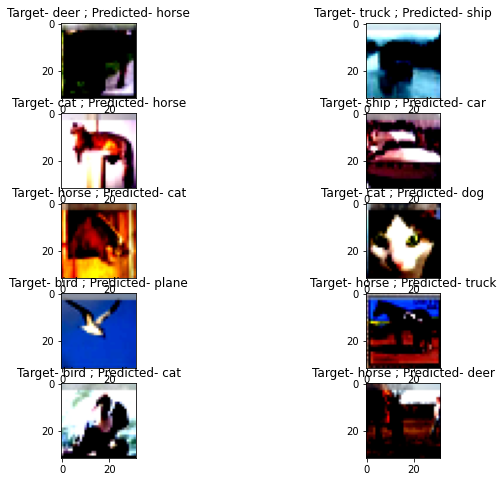



 crosstab of incorrect prediction to understand patterns: 



Predicted,bird,car,cat,deer,dog,frog,horse,plane,ship,truck
Actual,,,,,,,,,,
bird,0,2,35,36,21,28,12,40,4,6
car,2,0,1,0,0,2,0,9,15,37
cat,46,3,0,36,102,26,14,11,12,12
deer,34,1,29,0,14,20,21,6,8,2
dog,17,1,126,26,0,12,26,6,3,3
frog,21,2,36,15,4,0,4,5,3,4
horse,15,0,20,27,15,3,0,8,0,4
plane,16,10,11,9,1,1,6,0,33,16
ship,4,8,2,3,0,2,0,34,0,17


In [ ]:
from utils import plot_mispredictions
plot_mispredictions(net, device, testloader, target_classes, (10,8),10)


 # of incorrect images predicted in test dataset of 10000: 1295


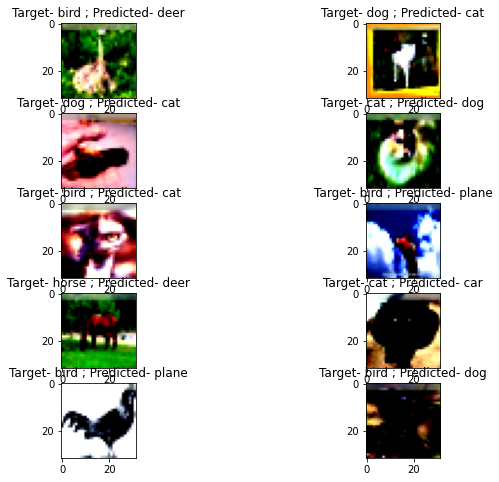



 crosstab of incorrect prediction to understand patterns: 



Predicted,bird,car,cat,deer,dog,frog,horse,plane,ship,truck
Actual,,,,,,,,,,
bird,0,2,35,36,21,28,12,40,4,6
car,2,0,1,0,0,2,0,9,15,37
cat,46,3,0,36,102,26,14,11,12,12
deer,34,1,29,0,14,20,21,6,8,2
dog,17,1,126,26,0,12,26,6,3,3
frog,21,2,36,15,4,0,4,5,3,4
horse,15,0,20,27,15,3,0,8,0,4
plane,16,10,11,9,1,1,6,0,33,16
ship,4,8,2,3,0,2,0,34,0,17


In [ ]:
from utils import plot_mispredictions
plot_mispredictions(net, device, testloader, target_classes, (10,8),10)

In [16]:
model_eval_f(net, device, testloader, target_classes)


Test set: Average loss: -9.5347, Accuracy: 8672/10000 (86.72%)


 class wise performance: 

  classes  accuracy
0   plane      82.1
1     car      95.5
2    bird      74.7
3     cat      82.5
4    deer      78.8
5     dog      88.6
6    frog      91.6
7   horse      89.4
8    ship      91.4
9   truck      92.6
              precision    recall  f1-score   support

        bird       0.84      0.82      0.83      1000
         car       0.91      0.95      0.93      1000
         cat       0.72      0.75      0.73      1000
        deer       0.89      0.82      0.85      1000
         dog       0.81      0.79      0.80      1000
        frog       0.92      0.89      0.90      1000
       horse       0.90      0.92      0.91      1000
       plane       0.86      0.89      0.88      1000
        ship       0.92      0.91      0.92      1000
       truck       0.91      0.93      0.92      1000

    accuracy                           0.87     10000
   macro avg       0.87      0.87    

In [20]:
!pip install grad-cam

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 49.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.4.6-py3-none-any.whl size=38261 sha256=06019aecd2b617afde459e7125695739717199df3d8387d1b8e3d0855e0fc996
  Stored in directory: /root/.cache/pip/wheels/53/02/43/1f75726b5c28459596067ad91e36951463c01273eef661f09f
Successfully built grad-cam


In [27]:
net.eval()

DataParallel(
  (module): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (shortcut): Sequential()
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       

In [28]:
net.module

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

## using the official pytorch-grad-cam library
https://jacobgil.github.io/pytorch-gradcam-book/introduction.html


In [29]:
from pytorch_grad_cam import GradCAM
target_layers = [net.module.layer4[-1]]

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


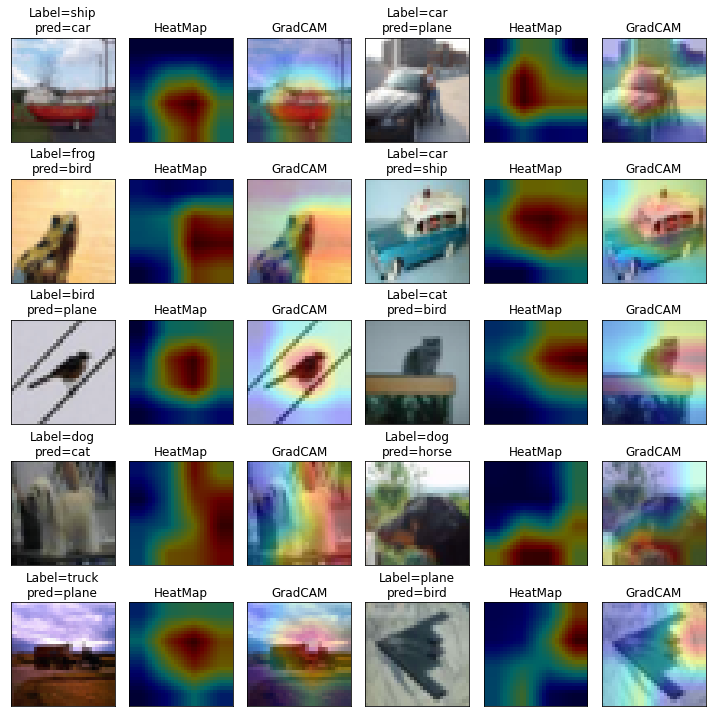

In [30]:
# Using gradcam from utility
from utils import plotGradCAM
# for layer4
plotGradCAM(net.module, testloader, target_classes, device)

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


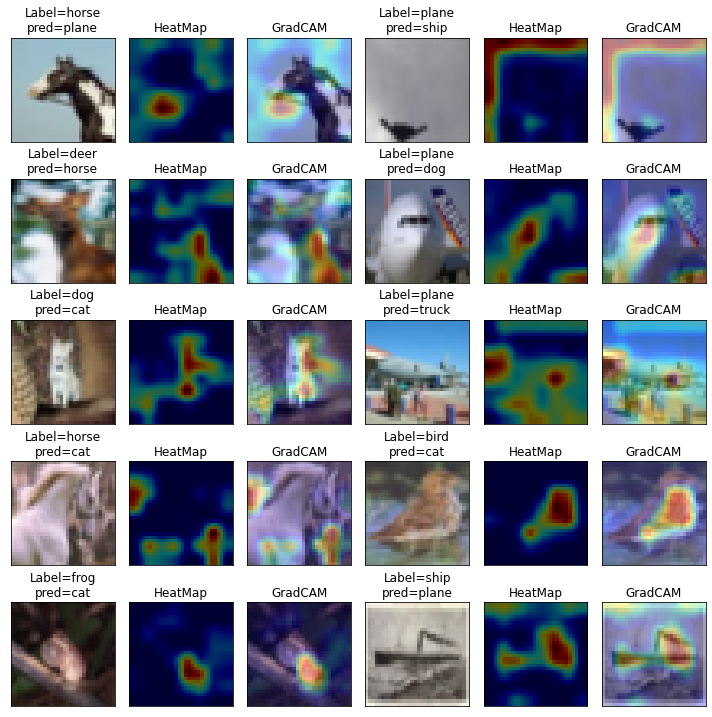

In [75]:
# for layer4
plotGradCAM(net.module, testloader, target_classes, device, 'layer3')

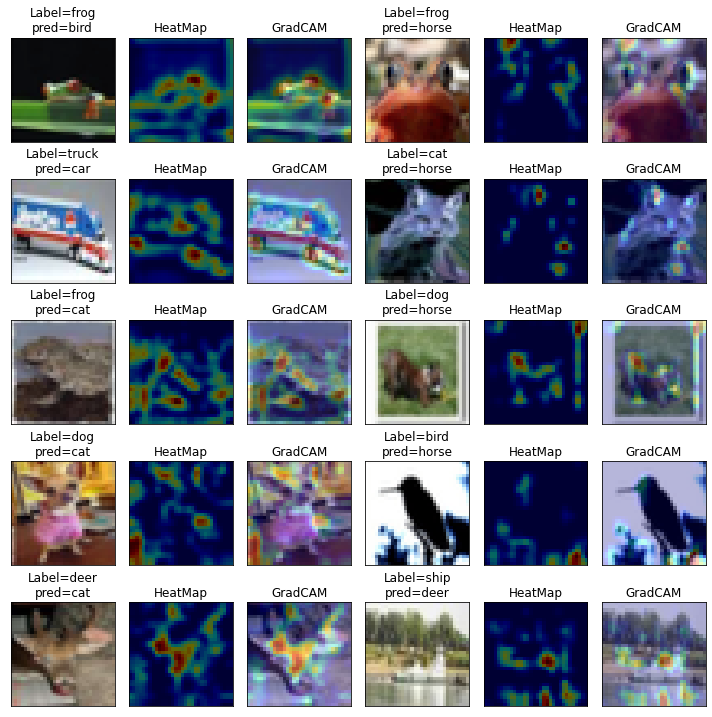

In [76]:
# for layer4
plotGradCAM(net.module, testloader, target_classes, device, 'layer2')

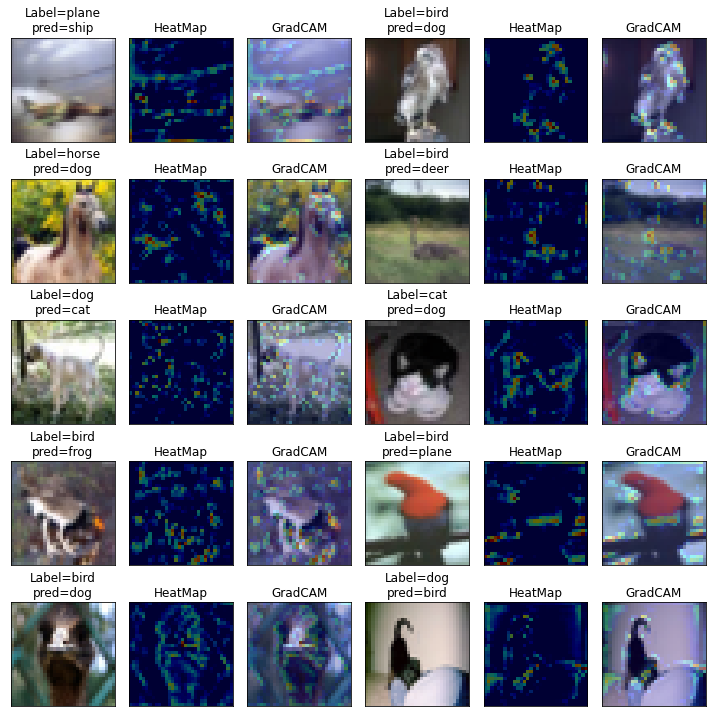

In [77]:
# for layer4
plotGradCAM(net.module, testloader, target_classes, device, 'layer1')

##END